# Load required library

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm.auto import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
torch.cuda.is_available()
device = "cuda"


# Intialize colours and category

In [3]:
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

number_of_classes = len(set(name_to_category.values()))

print(f"Number of classes {number_of_classes}") # Number of classes 
#print(name_to_category.values()) 

Number of classes 8


# Intilizing the data

1) Data is imported from respective folders
2) Then the raw image and mask image being split
3) Using mask image each pixel has beem assigned with class

Absolute Path: c:\DML\DML_Project_Group_80\train
Absolute Path: c:\DML\DML_Project_Group_80\val
Absolute Path: c:\DML\DML_Project_Group_80\city_train
Absolute Path: c:\DML\DML_Project_Group_80\city_val
size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500
size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


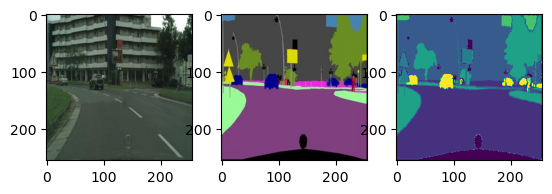

In [4]:
from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)


class CityscapesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_mask_dir = os.path.join(root_dir)
        print("Absolute Path:", os.path.abspath(self.image_mask_dir))
        self.file_list = os.listdir(self.image_mask_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]

        image_mask_path = os.path.join(self.image_mask_dir, file_name)
        img = Image.open(image_mask_path).convert('RGB')

        w, h = img.size
        #print(w)
        #print(h)

        # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
        img = np.asarray(img)
        #print(f"Input IMage size {img.shape}")
        raw, mask = img[:, :w//2, :], img[:, w//2:, :]
        #print(raw.shape)
        #print(mask.shape)

        height, width, channels = mask.shape
        #print(height)
        #print(width)
        #print(channels)

        distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
        #print(f"Distance {distances.shape}")
        classes = np.argmin(distances, axis=1).reshape(height, width)
        #print(classes.shape)

        # Optionally map categories to names
        classes = vectorized_cat_mapping(classes)

        #if self.transform:
            #raw_image = self.transform(raw_image)

        return raw, mask , classes

    def visualize(self, idx):
        x, mask_raw , classes = self.__getitem__(idx)
        print("size of input : ", x.shape)
        print("size of mask raw : ", mask_raw.shape)
        print("size of classes : ", classes.shape)
        plt.subplot(1, 3, 1)
        plt.imshow(x)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_raw)
        plt.subplot(1, 3, 3)
        plt.imshow(classes)
        plt.show()


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_path = CityscapesDataset(root_dir='train')
val_path =   CityscapesDataset(root_dir='val')
city_train_path = CityscapesDataset(root_dir='city_train', transform=transform)
city_val_path =   CityscapesDataset(root_dir='city_val', transform=transform)

print(f"size of training : {len(train_path)}")
print(f"size of cityscapes training : {len(city_train_path)}")
print(f"size of validation : {len(val_path)}")
print(f"size of cityscapes validation : {len(city_val_path)}")


# Visualize the first sample
train_path.visualize(0)

# Adding class to all the pixels in the image.

The above class function will be used to assign class to each pixel.

In [5]:
# Training Data

X_train, Y_train = [], []
X_val, Y_val = [], []

for index in tqdm(range(len(train_path))):
    X, _, Y = train_path.__getitem__(index)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

In [6]:
# Validation Data

for index in tqdm(range(len(val_path))):
    X, _, Y = val_path.__getitem__(index)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
# print data smaples used for training and validation
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}") 
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


# Normalization of data

In [14]:
# Class function is used to perfom the normalization operation.

class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y

Data Normalized using above class function

In [16]:
MEAN = [0.485, 0.456, 0.406] # Mean from the image net
STD = [0.229, 0.224, 0.225] # STD from the image net
BATCH_SIZE = 8 # Batch Size


# just normalize the data
preprocess = transforms.Compose([transforms.Normalize(mean=MEAN, std=STD),])
preprocess_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=MEAN, std=STD),
])

#transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))
# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Get one batch from the data loader
iterator = iter(train_dataloader)
batch = next(iterator)

# Check the shape of input tensors in the batch
inputs, labels = batch
print("Shape of inputs:", inputs.shape)
print("Shape of labels:", labels.shape)


Shape of inputs: torch.Size([8, 3, 256, 256])
Shape of labels: torch.Size([8, 256, 256])


# U-NET Network

In [17]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)  # Added dropout
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout(x)  # Added dropout
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1) 
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))

# Dice Loss Function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0.0001):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Flatten both the predicted and target tensors
        input_flat = input.flatten(0, 1)
        target_flat = target.flatten(0, 1)

        # Intersection and Union for each class
        intersection = (input_flat * target_flat).sum()
        union = input_flat.sum() + target_flat.sum()

        # Dice Similarity Coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        # Dice Loss
        dice_loss = 1. - dice
        return dice_loss

# IOU Loss Function

In [18]:
class IOULoss(nn.Module):
    def __init__(self, smooth=0.0001):
        super(IOULoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Flatten both the predicted and target tensors
        input_flat = input.flatten(0, 1)
        target_flat = target.flatten(0, 1)

        # Intersection and Union for each class
        intersection = (input_flat * target_flat).sum()
        union = input_flat.sum() + target_flat.sum()

        # IOU Similarity Coefficient
        IOU = (intersection + self.smooth) / (union + self.smooth - intersection)

        # Dice Loss
        IOU_loss = 1. - IOU
        return IOU_loss

# Confusion Matrix Function

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report

def calculate_confusion_matrix(y_true, y_pred, num_classes):
    # Convert predictions to class labels (assuming y_pred is logits)
    _, y_pred_labels = y_pred.max(dim=1)
    
    # Flatten the tensors to 1D arrays
    y_true_flat = y_true.view(-1).cpu().numpy()
    y_pred_flat = y_pred_labels.view(-1).cpu().numpy()

    # Calculate confusion matrix using sklearn
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))

    return conf_matrix

In [20]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(dataset, num_classes):
    # Assuming dataset is a torch Dataset with ground truth labels
    labels = []
    for _, label in dataset:
        labels.extend(label.flatten().cpu().numpy())
    class_weights = 0
    class_weights = compute_class_weight("balanced", classes=np.arange(num_classes), y=labels)
    return class_weights


In [21]:
# Calculate class weights
number_of_classes = 8
class_weights = calculate_class_weights(train_dataloader, num_classes=number_of_classes)

# Use weighted CrossEntropyLoss



# Train & Validation 

Function for Training 

In [23]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



def training_fun(model, train_dataloader, epochs, Beta, learing, CE, Dice, IOU):
    import torch.nn.functional as F

    optimizer = optim.Adam(model.parameters(), lr=learing, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

    # ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    dice_loss_fn = DiceLoss()
    IOU_loss_fn = IOULoss()
    #loss_fn = nn.CrossEntropyLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

    Total_loss = []
    Total_accuracy = []


    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        total_pixels = 0
        correct_pixels = 0

        for X, Y in train_dataloader:
            X, Y = X.to(device), Y.to(device)
            Y = Y.long()
            optimizer.zero_grad()
            Y_pred = model(X)

            # Choosing lossing fucntion based on Input
            if CE and not Dice and not IOU:
                CS_loss = loss_fn(Y_pred, Y)
                loss = CS_loss
            elif not CE and Dice and not IOU:
                dice_loss = dice_loss_fn(F.softmax(Y_pred, dim=1),
                                         F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                loss = dice_loss
            elif not CE and not Dice and IOU:
                IOU_loss = IOU_loss_fn(F.softmax(Y_pred, dim=1),
                                       F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                loss = IOU_loss
            elif CE and Dice and not IOU:
                dice_loss = dice_loss_fn(F.softmax(Y_pred, dim=1),
                                         F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                CS_loss = loss_fn(Y_pred, Y)
                loss = Beta * CS_loss + (1 - Beta) * dice_loss
            elif CE and not Dice and IOU:
                IOU_loss = IOU_loss_fn(F.softmax(Y_pred, dim=1),
                                       F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                CS_loss = loss_fn(Y_pred, Y)
                loss = Beta * CS_loss + (1 - Beta) * IOU_loss
            else:
                raise ValueError("Check your loop")

            loss.backward()
            optimizer.step()

            # Calculate pixel-wise accuracy
            _, predicted_labels = torch.max(Y_pred, dim=1)
            correct_pixels += (predicted_labels == Y).sum().item()
            total_pixels += Y.numel()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_dataloader)
        Total_loss.append(average_loss)
        accuracy = correct_pixels / total_pixels
        Total_accuracy.append(accuracy)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

        # Update the learning rate based on validation loss
        scheduler.step(average_loss)

    return Total_loss, Total_accuracy



Function for Validation

In [24]:
def val_fun(model,val_dataloader,epochs,Beta,CE,Dice,IOU):
    import torch.nn.functional as F
    
    dice_loss_fn = DiceLoss()
    IOU_loss_fn = IOULoss()
    loss_fn = nn.CrossEntropyLoss()
    image_no = []
    Total_loss = []
    Total_accuracy = []
    for epoch in tqdm(range(epochs)):
        model.eval()
        val_loss = 0
        val_total_pixels = 0
        val_correct_pixels = 0

        for X, Y in val_dataloader:
            X, Y = X.to(device), Y.to(device)
            j = X.shape[0]
            image_no.append(j)
            Y = Y.long()
            with torch.no_grad():
                Y_pred = model(X)
                # Choosing lossing fucntion based on Input
                if CE and not Dice and not IOU:
                    CS_loss = loss_fn(Y_pred, Y)
                    loss = CS_loss
                elif not CE and Dice and not IOU:
                    dice_loss = dice_loss_fn(F.softmax(Y_pred, dim=1), F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                    loss = dice_loss
                elif not CE and not Dice and  IOU:
                    IOU_loss = IOU_loss_fn(F.softmax(Y_pred, dim=1), F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                    loss = IOU_loss
                elif CE and Dice and  not IOU:
                    dice_loss = dice_loss_fn(F.softmax(Y_pred, dim=1), F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                    CS_loss = loss_fn(Y_pred, Y)
                    loss = Beta*CS_loss + (1-Beta)*dice_loss
                elif CE and not Dice and IOU:
                    IOU_loss = IOU_loss_fn(F.softmax(Y_pred, dim=1), F.one_hot(Y, num_classes=number_of_classes).permute(0, 3, 1, 2).float())
                    CS_loss = loss_fn(Y_pred, Y)
                    loss = Beta*CS_loss + (1-Beta)*IOU_loss
                else :
                    raise ValueError("Check your loop")
                
            _, predicted_val_labels = torch.max(Y_pred, 1)
            val_correct_pixels += (predicted_val_labels == Y).sum().item()
            val_total_pixels += Y.numel()
            val_loss += loss.item()
            
        #average_loss = val_loss/len(val_dataloader)
        average_loss = val_loss/len(image_no)
        Total_loss.append(average_loss)
        accuracy = val_correct_pixels/val_total_pixels
        Total_accuracy.append(accuracy)


        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

    return Total_loss , Total_accuracy , X , Y , predicted_val_labels , Y_pred 

# Cross Entropy loss function

Training 

In [33]:
model = Unet(3,number_of_classes)
model = model.to(device)
epoch = 30
Beta = 0.5
lr=1e-4

CE_Train_losses,CE_Train_accuracies = training_fun(model,train_dataloader,epoch,Beta,lr,CE = True,Dice = False ,IOU = False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 1.5184, Accuracy: 51.20%
Epoch 2/30, Loss: 1.0985, Accuracy: 63.32%
Epoch 3/30, Loss: 0.9185, Accuracy: 71.69%
Epoch 4/30, Loss: 0.8221, Accuracy: 75.38%
Epoch 5/30, Loss: 0.7573, Accuracy: 77.48%
Epoch 6/30, Loss: 0.7159, Accuracy: 78.52%
Epoch 7/30, Loss: 0.6861, Accuracy: 79.33%
Epoch 8/30, Loss: 0.6601, Accuracy: 79.97%
Epoch 9/30, Loss: 0.6365, Accuracy: 80.54%
Epoch 10/30, Loss: 0.6178, Accuracy: 80.96%
Epoch 11/30, Loss: 0.6045, Accuracy: 81.36%
Epoch 12/30, Loss: 0.5863, Accuracy: 81.68%
Epoch 13/30, Loss: 0.5745, Accuracy: 82.05%
Epoch 14/30, Loss: 0.5621, Accuracy: 82.30%
Epoch 15/30, Loss: 0.5547, Accuracy: 82.53%
Epoch 16/30, Loss: 0.5396, Accuracy: 82.81%
Epoch 17/30, Loss: 0.5353, Accuracy: 82.98%
Epoch 18/30, Loss: 0.5234, Accuracy: 83.35%
Epoch 19/30, Loss: 0.5145, Accuracy: 83.49%
Epoch 20/30, Loss: 0.5150, Accuracy: 83.44%
Epoch 21/30, Loss: 0.4979, Accuracy: 83.92%
Epoch 22/30, Loss: 0.4966, Accuracy: 83.84%
Epoch 23/30, Loss: 0.4904, Accuracy: 83.9

Validation

In [34]:

CE_Val_losses,CE_Val_accuracies,CE_raw,CE_truth,CE_pred,CE_data = val_fun(model,val_dataloader,epoch,Beta,CE = True,Dice = False ,IOU = False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4909, Accuracy: 85.08%
Epoch 2/30, Loss: 0.2454, Accuracy: 85.08%
Epoch 3/30, Loss: 0.1636, Accuracy: 85.08%
Epoch 4/30, Loss: 0.1227, Accuracy: 85.08%
Epoch 5/30, Loss: 0.0982, Accuracy: 85.08%
Epoch 6/30, Loss: 0.0818, Accuracy: 85.08%
Epoch 7/30, Loss: 0.0701, Accuracy: 85.08%
Epoch 8/30, Loss: 0.0614, Accuracy: 85.08%
Epoch 9/30, Loss: 0.0545, Accuracy: 85.08%
Epoch 10/30, Loss: 0.0491, Accuracy: 85.08%
Epoch 11/30, Loss: 0.0446, Accuracy: 85.08%
Epoch 12/30, Loss: 0.0409, Accuracy: 85.08%
Epoch 13/30, Loss: 0.0378, Accuracy: 85.08%
Epoch 14/30, Loss: 0.0351, Accuracy: 85.08%
Epoch 15/30, Loss: 0.0327, Accuracy: 85.08%
Epoch 16/30, Loss: 0.0307, Accuracy: 85.08%
Epoch 17/30, Loss: 0.0289, Accuracy: 85.08%
Epoch 18/30, Loss: 0.0273, Accuracy: 85.08%
Epoch 19/30, Loss: 0.0258, Accuracy: 85.08%
Epoch 20/30, Loss: 0.0245, Accuracy: 85.08%
Epoch 21/30, Loss: 0.0234, Accuracy: 85.08%
Epoch 22/30, Loss: 0.0223, Accuracy: 85.08%
Epoch 23/30, Loss: 0.0213, Accuracy: 85.0

# Dont Run it, it will erase the previously saved data

In [55]:
torch.save({'model_state_dict': model.state_dict(),
            'train_losses': CE_Train_losses,
            'train_accs': CE_Train_accuracies,
            'val_losses': CE_Val_losses,
            'val_accs': CE_Val_accuracies,
            'Raw': CE_raw,
            'truth': CE_truth,
            'pred': CE_pred,
            'data': CE_data,
            }, "./only_CE.ckpt")

# Graph 

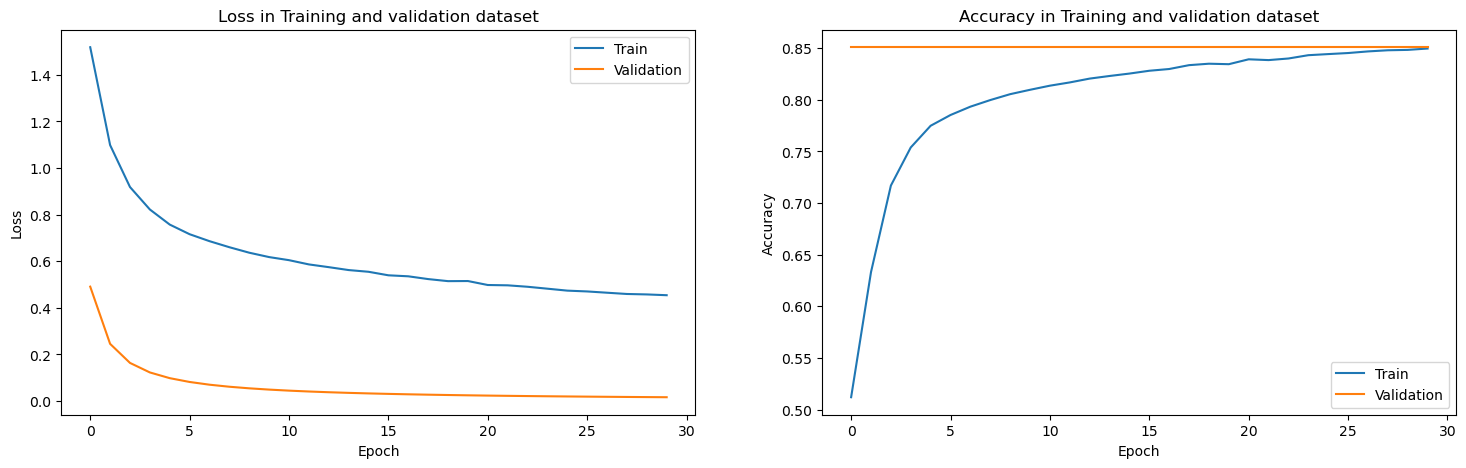

In [35]:
fig = plt.figure(figsize=(18,5))


# Plot for loss in the training and validation datasets
plt.subplot(1,2,1)
plt.plot(CE_Train_losses)
plt.plot(CE_Val_losses)
plt.title('Loss in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot for accuracy in the training and validation datasets
plt.subplot(1,2,2)
plt.plot(CE_Train_accuracies)
plt.plot(CE_Val_accuracies)
plt.title('Accuracy in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# printing the corresponding plots
plt.show()

# Dice Loss

Training Dice loss

In [22]:
model = Unet(3,number_of_classes)
model = model.to(device)
epoch = 8
Beta = 0.5
lr  = 0.1
DI_Train_losses,DI_Train_accuracies = training_fun(model,train_dataloader,epoch,Beta,lr,CE = False,Dice = True ,IOU = False)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8, Loss: 0.3596, Accuracy: 69.49%
Epoch 2/8, Loss: 0.2330, Accuracy: 77.10%
Epoch 3/8, Loss: 0.2188, Accuracy: 78.31%
Epoch 4/8, Loss: 0.2097, Accuracy: 79.15%
Epoch 5/8, Loss: 0.1753, Accuracy: 82.70%
Epoch 6/8, Loss: 0.1594, Accuracy: 84.20%
Epoch 7/8, Loss: 0.1534, Accuracy: 84.78%
Epoch 8/8, Loss: 0.1489, Accuracy: 85.21%


Validation

In [23]:
DI_Val_losses,DI_Val_accuracies,DI_raw,DI_truth,DI_pred,DI_data = val_fun(model,val_dataloader,epoch,Beta,CE = True,Dice = False ,IOU = False)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 2/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 3/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 4/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 5/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 6/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 7/8, Loss: 1.7778, Accuracy: 81.81%
Epoch 8/8, Loss: 1.7778, Accuracy: 81.81%


In [31]:
torch.save({'model_state_dict': model.state_dict(),
            'train_losses': DI_Train_losses,
            'train_accs': DI_Train_accuracies,
            'val_losses': DI_Val_losses,
            'val_accs': DI_Val_accuracies,
            'Raw': DI_raw,
            'truth': DI_truth,
            'pred': DI_pred,
            'data': DI_data,
            }, "./only_DI.ckpt")

# Graph

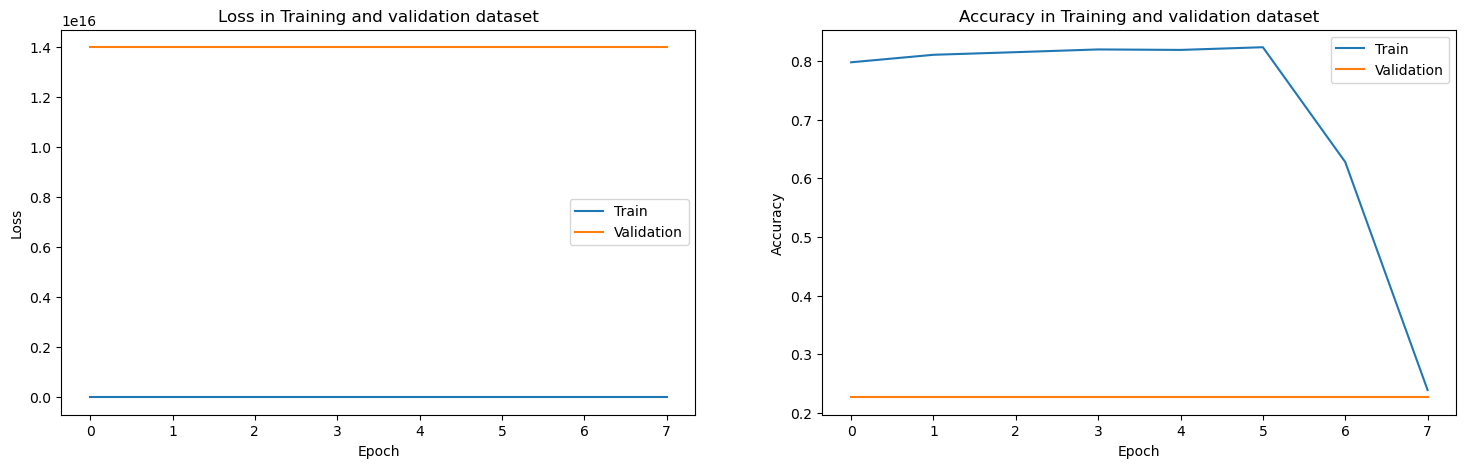

In [ ]:
fig = plt.figure(figsize=(18,5))


# Plot for loss in the training and validation datasets
plt.subplot(1,2,1)
plt.plot(DI_Train_losses)
plt.plot(DI_Val_losses)
plt.title('Loss in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot for accuracy in the training and validation datasets
plt.subplot(1,2,2)
plt.plot(DI_Train_accuracies)
plt.plot(DI_Val_accuracies)
plt.title('Accuracy in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# printing the corresponding plots
plt.show()

# CE+DICE Loss

In [42]:
model = Unet(3,number_of_classes)
model = model.to(device)
epoch = 30
Beta = 0.65
lr  = 1e-4

CEDI_Train_losses,CEDI_Train_accuracies = training_fun(model,train_dataloader,epoch,Beta,lr,CE = True,Dice = True ,IOU = False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 1.1926, Accuracy: 55.15%
Epoch 2/30, Loss: 0.8714, Accuracy: 74.07%
Epoch 3/30, Loss: 0.7316, Accuracy: 77.62%
Epoch 4/30, Loss: 0.6468, Accuracy: 79.29%
Epoch 5/30, Loss: 0.5960, Accuracy: 80.63%
Epoch 6/30, Loss: 0.5622, Accuracy: 81.44%
Epoch 7/30, Loss: 0.5368, Accuracy: 81.94%
Epoch 8/30, Loss: 0.5141, Accuracy: 82.54%
Epoch 9/30, Loss: 0.5005, Accuracy: 82.83%
Epoch 10/30, Loss: 0.4847, Accuracy: 83.24%
Epoch 11/30, Loss: 0.4749, Accuracy: 83.44%
Epoch 12/30, Loss: 0.4647, Accuracy: 83.73%
Epoch 13/30, Loss: 0.4532, Accuracy: 84.01%
Epoch 14/30, Loss: 0.4439, Accuracy: 84.33%
Epoch 15/30, Loss: 0.4382, Accuracy: 84.36%
Epoch 16/30, Loss: 0.4292, Accuracy: 84.66%
Epoch 17/30, Loss: 0.4217, Accuracy: 84.88%
Epoch 18/30, Loss: 0.4141, Accuracy: 85.08%
Epoch 19/30, Loss: 0.4098, Accuracy: 85.07%
Epoch 20/30, Loss: 0.4041, Accuracy: 85.32%
Epoch 21/30, Loss: 0.3987, Accuracy: 85.40%
Epoch 22/30, Loss: 0.3905, Accuracy: 85.70%
Epoch 23/30, Loss: 0.3916, Accuracy: 85.5

In [43]:
CEDI_Val_losses,CEDI_Val_accuracies,CEDI_raw,CEDI_truth,CEDI_pred,CEDI_data = val_fun(model,val_dataloader,epoch,Beta,CE = True,Dice = True ,IOU = False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4005, Accuracy: 84.94%
Epoch 2/30, Loss: 0.2003, Accuracy: 84.94%
Epoch 3/30, Loss: 0.1335, Accuracy: 84.94%
Epoch 4/30, Loss: 0.1001, Accuracy: 84.94%
Epoch 5/30, Loss: 0.0801, Accuracy: 84.94%
Epoch 6/30, Loss: 0.0668, Accuracy: 84.94%
Epoch 7/30, Loss: 0.0572, Accuracy: 84.94%
Epoch 8/30, Loss: 0.0501, Accuracy: 84.94%
Epoch 9/30, Loss: 0.0445, Accuracy: 84.94%
Epoch 10/30, Loss: 0.0401, Accuracy: 84.94%
Epoch 11/30, Loss: 0.0364, Accuracy: 84.94%
Epoch 12/30, Loss: 0.0334, Accuracy: 84.94%
Epoch 13/30, Loss: 0.0308, Accuracy: 84.94%
Epoch 14/30, Loss: 0.0286, Accuracy: 84.94%
Epoch 15/30, Loss: 0.0267, Accuracy: 84.94%
Epoch 16/30, Loss: 0.0250, Accuracy: 84.94%
Epoch 17/30, Loss: 0.0236, Accuracy: 84.94%
Epoch 18/30, Loss: 0.0223, Accuracy: 84.94%
Epoch 19/30, Loss: 0.0211, Accuracy: 84.94%
Epoch 20/30, Loss: 0.0200, Accuracy: 84.94%
Epoch 21/30, Loss: 0.0191, Accuracy: 84.94%
Epoch 22/30, Loss: 0.0182, Accuracy: 84.94%
Epoch 23/30, Loss: 0.0174, Accuracy: 84.9

In [56]:
torch.save({'model_state_dict': model.state_dict(),
            'train_losses': CEDI_Train_losses,
            'train_accs': CEDI_Train_accuracies,
            'val_losses': CEDI_Val_losses,
            'val_accs': CEDI_Val_accuracies,
            'Raw': CEDI_raw,
            'truth': CEDI_truth,
            'pred': CEDI_pred,
            'data': CEDI_data,
            }, "./only_CEDI.ckpt")

# CE + IOU

In [38]:
model = Unet(3,number_of_classes)
model = model.to(device)
epoch = 30
Beta = 0.35
lr  = 1e-4

CEIOU_Train_losses,CEIOU_Train_accuracies = training_fun(model,train_dataloader,epoch,Beta,lr,CE = True,Dice = False ,IOU = True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 1.0792, Accuracy: 45.62%
Epoch 2/30, Loss: 0.8340, Accuracy: 74.47%
Epoch 3/30, Loss: 0.6915, Accuracy: 79.94%
Epoch 4/30, Loss: 0.6010, Accuracy: 81.70%
Epoch 5/30, Loss: 0.5473, Accuracy: 82.99%
Epoch 6/30, Loss: 0.5126, Accuracy: 83.81%
Epoch 7/30, Loss: 0.4875, Accuracy: 84.45%
Epoch 8/30, Loss: 0.4706, Accuracy: 84.94%
Epoch 9/30, Loss: 0.4567, Accuracy: 85.36%
Epoch 10/30, Loss: 0.4474, Accuracy: 85.58%
Epoch 11/30, Loss: 0.4374, Accuracy: 85.84%
Epoch 12/30, Loss: 0.4285, Accuracy: 86.04%
Epoch 13/30, Loss: 0.4194, Accuracy: 86.39%
Epoch 14/30, Loss: 0.4147, Accuracy: 86.49%
Epoch 15/30, Loss: 0.4042, Accuracy: 86.80%
Epoch 16/30, Loss: 0.4002, Accuracy: 86.88%
Epoch 17/30, Loss: 0.3938, Accuracy: 87.11%
Epoch 18/30, Loss: 0.3897, Accuracy: 87.19%
Epoch 19/30, Loss: 0.3844, Accuracy: 87.28%
Epoch 20/30, Loss: 0.3792, Accuracy: 87.49%
Epoch 21/30, Loss: 0.3752, Accuracy: 87.57%
Epoch 22/30, Loss: 0.3704, Accuracy: 87.71%
Epoch 23/30, Loss: 0.3684, Accuracy: 87.8

In [39]:
CEIOU_Val_losses,CEIOU_Val_accuracies,CEIOU_raw,CEIOU_truth,CEIOU_pred,CEIOU_data = val_fun(model,val_dataloader,epoch,Beta,CE = True,Dice = False ,IOU = True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.3735, Accuracy: 85.87%
Epoch 2/30, Loss: 0.1868, Accuracy: 85.87%
Epoch 3/30, Loss: 0.1245, Accuracy: 85.87%
Epoch 4/30, Loss: 0.0934, Accuracy: 85.87%
Epoch 5/30, Loss: 0.0747, Accuracy: 85.87%
Epoch 6/30, Loss: 0.0623, Accuracy: 85.87%
Epoch 7/30, Loss: 0.0534, Accuracy: 85.87%
Epoch 8/30, Loss: 0.0467, Accuracy: 85.87%
Epoch 9/30, Loss: 0.0415, Accuracy: 85.87%
Epoch 10/30, Loss: 0.0374, Accuracy: 85.87%
Epoch 11/30, Loss: 0.0340, Accuracy: 85.87%
Epoch 12/30, Loss: 0.0311, Accuracy: 85.87%
Epoch 13/30, Loss: 0.0287, Accuracy: 85.87%
Epoch 14/30, Loss: 0.0267, Accuracy: 85.87%
Epoch 15/30, Loss: 0.0249, Accuracy: 85.87%
Epoch 16/30, Loss: 0.0233, Accuracy: 85.87%
Epoch 17/30, Loss: 0.0220, Accuracy: 85.87%
Epoch 18/30, Loss: 0.0208, Accuracy: 85.87%
Epoch 19/30, Loss: 0.0197, Accuracy: 85.87%
Epoch 20/30, Loss: 0.0187, Accuracy: 85.87%
Epoch 21/30, Loss: 0.0178, Accuracy: 85.87%
Epoch 22/30, Loss: 0.0170, Accuracy: 85.87%
Epoch 23/30, Loss: 0.0162, Accuracy: 85.8

In [57]:
torch.save({'model_state_dict': model.state_dict(),
            'train_losses': CEIOU_Train_losses,
            'train_accs': CEIOU_Train_accuracies,
            'val_losses': CEIOU_Val_losses,
            'val_accs': CEIOU_Val_accuracies,
            'Raw': CEIOU_raw,
            'truth': CEIOU_truth,
            'pred': CEIOU_pred,
            'data': CEIOU_data,
            }, "./only_CEIOU.ckpt")

# Comparision

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


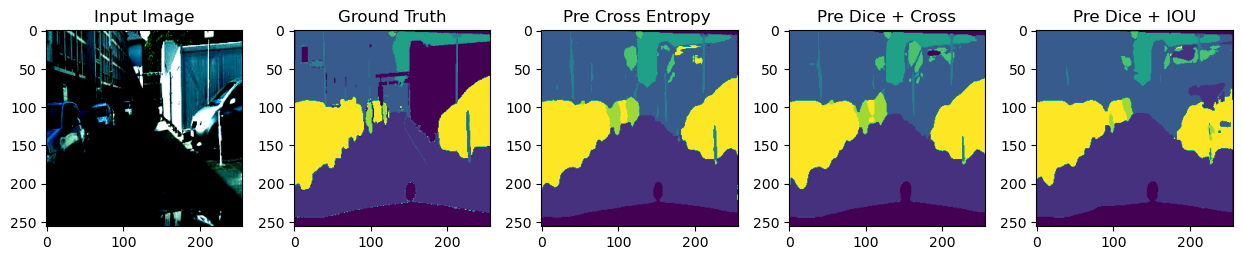

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


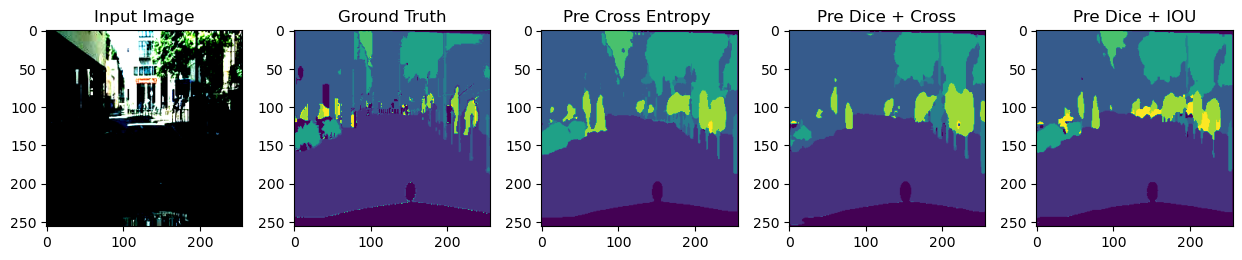

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


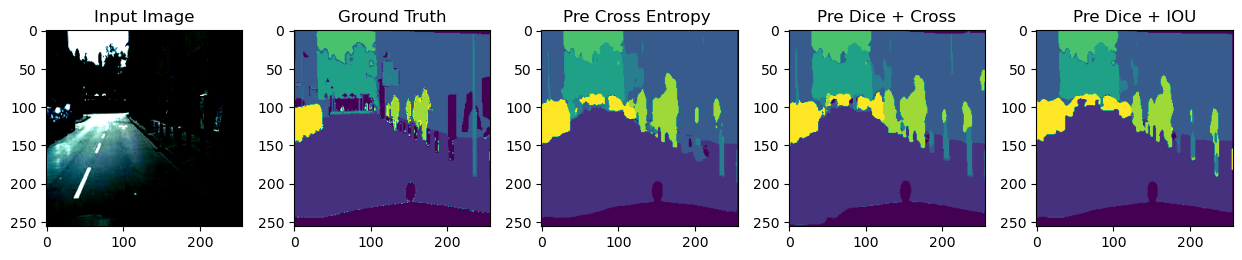

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


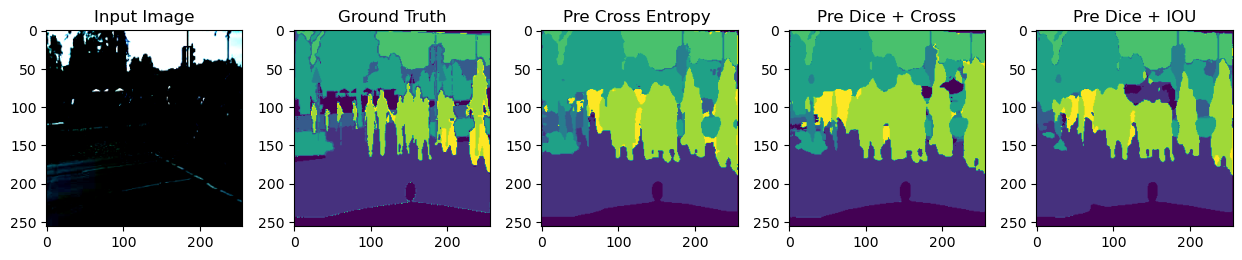

In [47]:


for i in range(len(CE_raw)):  # Use dynamic batch size
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 6, 1)
    plt.imshow(np.transpose(CE_raw[i].cpu().numpy(), (1, 2, 0)))
    plt.title('Input Image')

    plt.subplot(1, 6, 2)
    plt.imshow(CE_truth[i].cpu().numpy(), cmap='viridis', vmin=0, vmax=number_of_classes - 1)
    plt.title('Ground Truth')

    plt.subplot(1, 6, 3)
    plt.imshow(CE_pred[i].cpu().numpy(), cmap='viridis', vmin=0, vmax=number_of_classes - 1)
    plt.title('Pre Cross Entropy ')

    #plt.subplot(1, 6, 4)
    #plt.imshow(DI_pred[i].cpu().numpy(), cmap='viridis', vmin=0, vmax=number_of_classes - 1)
    #plt.title('Pre Dice loss')

    plt.subplot(1, 6, 4)
    plt.imshow(CEDI_pred [i].cpu().numpy(), cmap='viridis', vmin=0, vmax=number_of_classes - 1)
    plt.title('Pre Dice + Cross')

    plt.subplot(1, 6, 5)
    plt.imshow(CEIOU_pred [i].cpu().numpy(), cmap='viridis', vmin=0, vmax=number_of_classes - 1)
    plt.title('Pre Dice + IOU')


    plt.tight_layout()  # Adjust subplot layout
    plt.show()



In [ ]:
num_classes = 8  

conf_matrix = calculate_confusion_matrix(Y,Y_pred, num_classes)
print(conf_matrix)
sns.heatmap(conf_matrix,annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

raw,truth,pred

In [ ]:
import torch
from sklearn.metrics import classification_report
y_true_flat = truth.view(-1).cpu().numpy()
print(y_true_flat.shape)
y_pred_flat = pred.argmax(dim=1).view(-1).cpu().numpy()
print(y_pred_flat.shape)
report = classification_report(y_true_flat, y_pred_flat)
print(report)

(262144,)
(262144,)
              precision    recall  f1-score   support

           0       0.95      0.55      0.70     45319
           1       0.98      0.89      0.93     94525
           2       0.51      0.90      0.65     57699
           3       0.00      0.00      0.00      3751
           4       0.83      0.63      0.72     25744
           5       0.78      0.99      0.87      7841
           6       0.27      0.00      0.01      9513
           7       0.72      0.76      0.74     17752

    accuracy                           0.76    262144
   macro avg       0.63      0.59      0.58    262144
weighted avg       0.79      0.76      0.75    262144

